# PRO

In [75]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

In [76]:
# Função para imprimir e salvar matriz de confusão
def imprimeMatrizDeConfusão(y_test, preds, model, salvarFigura = False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    if(salvarFigura):
        plt.savefig(input('Nome da figura a ser salva:' ) + '.png')
    plt.show()

In [77]:
def treinar_e_roportar(models, X_train, y_train, X_test, y_test):
    for model in models:
        print(model)
        if(model == xgb_model):
            y_train = enc.transform(y_train.array.reshape(-1, 1))
            y_test = enc.transform(y_test.array.reshape(-1, 1))
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        print('Acurácia teste: ', accuracy_score(y_test, preds)*100)
        print(classification_report(y_test, preds, digits=3))
        imprimeMatrizDeConfusão(y_test, preds, model)
        preds = model.predict(X_train)
        print('Acurácia treino: ', accuracy_score(y_train, preds)*100)
        print(classification_report(y_train, preds, digits=3))   

In [78]:
# Função do Bresolin

def metrics(curr_path, outdir, path_inference, cfgname, task, nclass, thr, proc):
    '''
    Get all metrics and save in text file
    '''    
    pred = pd.read_table(os.path.join(curr_path, outdir, path_inference, cfgname.replace('.cfg', '.pred')), header = None, sep = ' ').to_numpy()
    if task == 'class':
        y_obs = pred[:,0].astype(int)
        y_pred = (pred[:,1] > thr).astype('int')
        cm_mat = confusion_matrix(y_obs, y_pred)
       
        if cm_mat.shape[0] != cm_mat.shape[1]:
            sys.exit('Error: Number of true and predicted classes are different.\
                     Please contact the developer: tgbresolin@gmail.com!!!\n')
        elif cm_mat.shape[0] == 1:
            sys.exit('Error: Number of true classes are equal 1.\
                     Please contact the developer: tgbresolin@gmail.com!!!\n')
        elif cm_mat.shape[1] == 1:
            sys.exit('Error: Number of predicted classes are equal 1.\
                     Please contact the developer: tgbresolin@gmail.com!!!\n')  
        metrics = []
       
        if nclass == 2:
            tp = cm_mat[1,1]
            tn = cm_mat[0,0]
            fp = cm_mat[0,1]
            fn = cm_mat[1,0]
            acc = round(((tp + tn) / (tp + tn + fp + fn)), 2) * 100
            err = 100 - acc
            sen = round((tp / (tp + fn)), 2) * 100
            spe = round((tn / (tn + fp)), 2) * 100
            ppv = round((tp / (tp + fp)), 2) * 100
            npv = round((tn / (tn + fn)), 2) * 100
            metrics = pd.DataFrame(data = {'ACC': [acc], 'ERR': [err], 'SEN': [sen],
                                           'SPE': [spe], 'PPV': [ppv], 'NPV': [npv]})
        # else: for more than 2 two classes
    else:
        stats = np.load(os.path.join(curr_path, outdir, 'data/train/stats.npy'), mmap_mode = 'r')
        pred = backTransform(pred, stats, proc)
        x = pred[:,1]
        y = pred[:,0]
        mse = (1/ len(x)) * np.sum((y - x)**2)
        rmse = mt.sqrt(mse)
       
        x = x.reshape((-1, 1))
        model = LinearRegression().fit(x, y)
        r2 = model.score(x, y)
        slope = model.coef_[0]
        metrics = pd.DataFrame(data = {'R2': [r2], 'Slope': [slope], 'MSE': [mse], 'RMSE': [rmse]})
    metrics.to_csv(os.path.join(curr_path, outdir, path_inference, cfgname.replace('.cfg','.stat')), sep = ' ', header = True, mode = 'w', decimal = '.', index = False)

## Leave One Group Out

In [79]:
from sklearn.model_selection import LeaveOneGroupOut
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [94]:
# Modelos PRO
lgb_model = LGBMClassifier(learning_rate=0.1, num_leaves=512, min_child_samples=1, subsample=1.0, 
                           colsample_bytree=0.662, random_state=0, subsample_freq=1, n_estimators=100, n_jobs=-1)

rf_model = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=None, 
                                  criterion='entropy', min_samples_split=10, min_samples_leaf=2 , bootstrap=True, random_state=0, n_jobs=-1)

knn_model = KNeighborsClassifier(n_neighbors=37, weights='distance', leaf_size=20, p=1, n_jobs=-1)

xgb_model = XGBClassifier(learning_rate=0.1, max_depth=16, min_child_weight=1, gamma=0.0, colsample_bytree=0.5370264280766771, use_label_encoder=False, random_state=0, n_jobs=-1)

rn_model = MLPClassifier(hidden_layer_sizes=(20,30,30,20), activation="tanh", learning_rate="adaptive", random_state=0)

models = [lgb_model, rf_model, knn_model, rn_model, xgb_model]

In [95]:
models=[rn_model]

In [96]:
caminho_dados_lazaro = 'Datasets/Lazaro/dados_pre_processados_lazaro.csv'

In [97]:
df = pd.read_csv(caminho_dados_lazaro)

In [98]:
# Remove as linhas com o sensor 434138
df = df[df.SensorID != 434138]

In [99]:
df.columns

Index(['Piquete', 'Altura real', 'Altura esperada', 'Animal', 'SensorID',
       'Sensor Name', 'Date', 'X', 'Y', 'Z', 'Comportamento', 'Season_fall',
       'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol',
       'icl'],
      dtype='object')

#### Divisão entre variáveis preditoras(X) e variáveis de resposta(y)

In [100]:
y = df.Comportamento
X = df[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]

enc = OrdinalEncoder()
enc.fit(y.array.reshape(-1, 1))

OrdinalEncoder()

In [10]:
# Conjunto de dados PNP: Pastejando x Não Pastejando
y = y.replace(to_replace=['Ocio', 'Ruminando'], value='Não Pastejando')

In [101]:
# Para reescalar os dados
from sklearn.preprocessing import StandardScaler

X_season = X[['Season_fall', 'Season_spring', 'Season_summer']]

X = X.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1)

columns = X.columns
index= X.index

sc = StandardScaler()
X = sc.fit_transform(X)

X = pd.DataFrame(X, columns=columns, index=index)

X = pd.concat([X, X_season], axis=1)

#### Leave Fall Out

In [47]:
df_test = df[df.Season_fall == 1]

In [48]:
df_train = df[df.Season_fall == 0]

In [49]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 30, 30, 20),
              learning_rate='adaptive', random_state=0)


/home/caio/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Acurácia teste:  56.36885408929101
              precision    recall  f1-score   support

        Ocio      0.267     0.076     0.118     41581
  Pastejando      0.601     0.895     0.719    146629
   Ruminando      0.274     0.076     0.119     58153

    accuracy                          0.564    246363
   macro avg      0.381     0.349     0.319    246363
weighted avg      0.468     0.564     0.476    246363



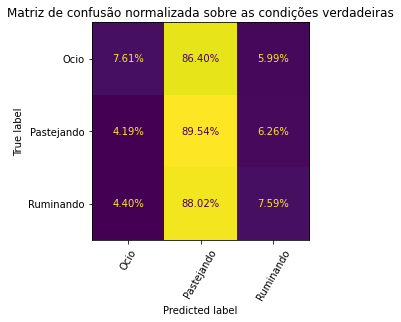

Acurácia treino:  66.66869926022834
              precision    recall  f1-score   support

        Ocio      0.559     0.281     0.374     81676
  Pastejando      0.706     0.860     0.775    185883
   Ruminando      0.619     0.620     0.619     93228

    accuracy                          0.667    360787
   macro avg      0.628     0.587     0.589    360787
weighted avg      0.650     0.667     0.644    360787



In [37]:
treinar_e_roportar(models, X_train, y_train, X_test, y_test)   

#### Leave Height Out 10 cm

In [38]:
df_test = df[df['Altura esperada'] == 10.0]

In [39]:
df_train = df[df['Altura esperada'] != 10.0]

In [40]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 30, 30, 20),
              learning_rate='adaptive', random_state=0)
Acurácia teste:  50.8109530976856
              precision    recall  f1-score   support

        Ocio      0.292     0.081     0.127     40651
  Pastejando      0.582     0.805     0.676     83076
   Ruminando      0.231     0.208     0.219     24432

    accuracy                          0.508    148159
   macro avg      0.369     0.365     0.341    148159
weighted avg      0.445     0.508     0.450    148159



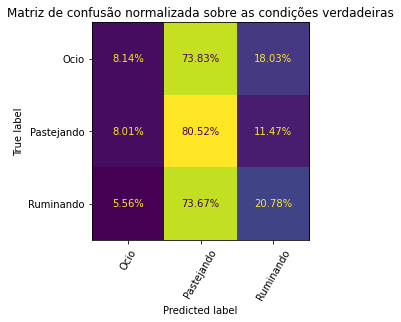

Acurácia treino:  70.99333102391986
              precision    recall  f1-score   support

        Ocio      0.541     0.257     0.348     82606
  Pastejando      0.767     0.864     0.813    249436
   Ruminando      0.643     0.701     0.671    126949

    accuracy                          0.710    458991
   macro avg      0.650     0.607     0.610    458991
weighted avg      0.692     0.710     0.690    458991



In [41]:
treinar_e_roportar(models, X_train, y_train, X_test, y_test) 

#### Leave Animals Out

In [102]:
df.Animal.value_counts()

95     119449
81     113724
84     110268
93      98043
21      58809
22      58734
90      47549
105       574
Name: Animal, dtype: int64

In [103]:
df_test = df.loc[df['Animal'].isin([84, 93])]

In [104]:
df_test.Animal.value_counts()

84    110268
93     98043
Name: Animal, dtype: int64

In [105]:
df_train = df.loc[~df['Animal'].isin([84, 93])]

In [106]:
df_train.Animal.value_counts()

95     119449
81     113724
21      58809
22      58734
90      47549
105       574
Name: Animal, dtype: int64

In [107]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento

LGBMClassifier(colsample_bytree=0.662, min_child_samples=1, num_leaves=512,
               random_state=0, subsample_freq=1)
Acurácia teste:  52.925673632213375
              precision    recall  f1-score   support

        Ocio      0.286     0.148     0.195     37531
  Pastejando      0.590     0.842     0.694    114197
   Ruminando      0.328     0.151     0.206     56583

    accuracy                          0.529    208311
   macro avg      0.401     0.380     0.365    208311
weighted avg      0.464     0.529     0.472    208311



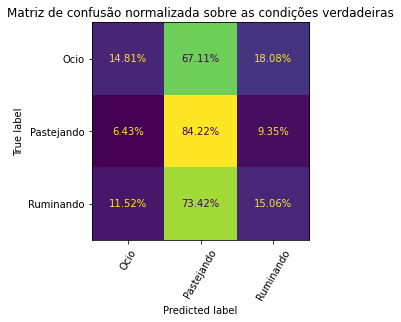

Acurácia treino:  79.1229042295262
              precision    recall  f1-score   support

        Ocio      0.770     0.513     0.616     85726
  Pastejando      0.806     0.927     0.862    218315
   Ruminando      0.762     0.731     0.746     94798

    accuracy                          0.791    398839
   macro avg      0.780     0.723     0.741    398839
weighted avg      0.788     0.791     0.782    398839

RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=0)
Acurácia teste:  52.07406233948279
              precision    recall  f1-score   support

        Ocio      0.264     0.142     0.185     37531
  Pastejando      0.585     0.835     0.688    114197
   Ruminando      0.312     0.138     0.191     56583

    accuracy                          0.521    208311
   macro avg      0.387     0.372     0.355    208311
weighted avg      0.453  

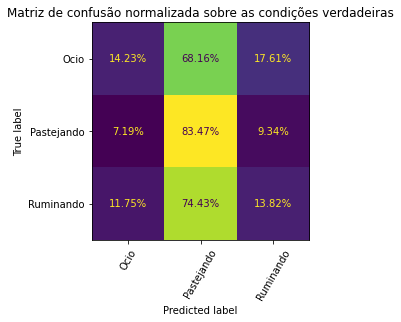

Acurácia treino:  89.7580226607729
              precision    recall  f1-score   support

        Ocio      0.926     0.762     0.836     85726
  Pastejando      0.890     0.969     0.928    218315
   Ruminando      0.895     0.857     0.875     94798

    accuracy                          0.898    398839
   macro avg      0.904     0.862     0.880    398839
weighted avg      0.899     0.898     0.896    398839

KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=37, p=1,
                     weights='distance')
Acurácia teste:  48.917723980010656
              precision    recall  f1-score   support

        Ocio      0.225     0.130     0.165     37531
  Pastejando      0.569     0.763     0.652    114197
   Ruminando      0.294     0.175     0.219     56583

    accuracy                          0.489    208311
   macro avg      0.363     0.356     0.345    208311
weighted avg      0.433     0.489     0.447    208311



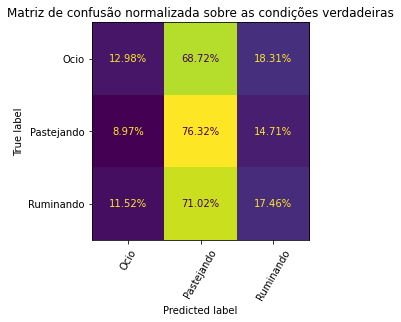

Acurácia treino:  99.9882157963489
              precision    recall  f1-score   support

        Ocio      1.000     1.000     1.000     85726
  Pastejando      1.000     1.000     1.000    218315
   Ruminando      1.000     1.000     1.000     94798

    accuracy                          1.000    398839
   macro avg      1.000     1.000     1.000    398839
weighted avg      1.000     1.000     1.000    398839

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5370264280766771,
              enable_categorical=False, gamma=0.0, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=16,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=0, reg_alpha=None, reg_lambda=None,
              scale_pos

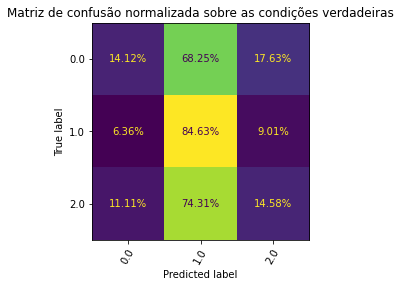

Acurácia treino:  92.85225366626634
              precision    recall  f1-score   support

         0.0      0.956     0.812     0.878     85726
         1.0      0.927     0.976     0.951    218315
         2.0      0.911     0.923     0.917     94798

    accuracy                          0.929    398839
   macro avg      0.932     0.904     0.916    398839
weighted avg      0.930     0.929     0.927    398839

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 30, 30, 20),
              learning_rate='adaptive', random_state=0)


/home/caio/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Acurácia teste:  49.49042537360005
              precision    recall  f1-score   support

         0.0      0.262     0.126     0.170     37531
         1.0      0.561     0.798     0.659    114197
         2.0      0.260     0.127     0.171     56583

    accuracy                          0.495    208311
   macro avg      0.361     0.351     0.333    208311
weighted avg      0.425     0.495     0.438    208311



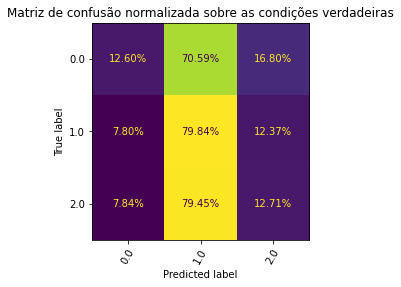

Acurácia treino:  69.9129222568505
              precision    recall  f1-score   support

         0.0      0.566     0.309     0.400     85726
         1.0      0.746     0.881     0.808    218315
         2.0      0.636     0.634     0.635     94798

    accuracy                          0.699    398839
   macro avg      0.650     0.608     0.614    398839
weighted avg      0.681     0.699     0.679    398839



In [93]:
treinar_e_roportar(models, X_train, y_train, X_test, y_test)